** Objective: ** 
** To develop a statistical model for predicting whether questions will be upvoted, downvoted, or closed based on their text. ** 
** To predict how long questions will take to answer. **

** Authors: Rachit Rawat, Rudradeep Guha, Vineet Nandkishore **

# 0. Setup Environment

In [1]:
# load required packages

# for creating dataframes from csv datasets
import pandas as pd

# for regular expressions
import re

# for stripping stop words
from nltk.corpus import stopwords

# for TF-IDF
from textblob import TextBlob as tb

# for removing HTML tags from text body
from html.parser import HTMLParser

# for counting
import collections

# for scientific computing
import numpy as np
import math

# for plotting graphs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# magic function
%matplotlib inline

# kaggle - data set files are available in the "../input/" directory
dataset_dir = "../input/"
dataset_dir_questions = "Questions.csv"
dataset_dir_answers = "Answers.csv"
dataset_dir_tags = "Tags.csv"

# for offline run
# dataset_dir = "/home/su/Downloads/stacksample"

# list the files in the dataset directory
from subprocess import check_output
print(check_output(["ls", dataset_dir]).decode("utf8"))

cachedStopWords = stopwords.words("english")



Answers.csv
Questions.csv
Tags.csv



** 0.1 HTML tags Stripper class **

In [2]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

** 0.2 TF-IDF helper fucntions **

In [3]:
# tf(word, blob) computes "term frequency" which is the number of times 
# a word appears in a document blob,normalized by dividing by 
# the total number of words in blob. 
# We use TextBlob for breaking up the text into words and getting the word counts.
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

# n_containing(word, bloblist) returns the number of documents containing word.
# A generator expression is passed to the sum() function.
def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

# idf(word, bloblist) computes "inverse document frequency" which measures how common 
# a word is among all documents in bloblist. 
# The more common a word is, the lower its idf. 
# We take the ratio of the total number of documents 
# to the number of documents containing word, then take the log of that. 
# Add 1 to the divisor to prevent division by zero.
def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

# tfidf(word, blob, bloblist) computes the TF-IDF score. 
# It is simply the product of tf and idf.
def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

** 0.3 Normalizer function **
* strip HTML tags
* strip stop words and symbols 
* convert to lowercase
* strip single characters
* strip words that are all numbers 

In [4]:
def normalize(str):
    return ' '.join([word for word in re.sub(r'[^\w]', ' ', strip_tags(str)).lower().split() if word not in cachedStopWords and len(word) > 1 and not word.isdigit()])


# 1. Preprocessing
**1.1 pandas - load CSV into dataframe **


In [5]:
# Read CSV

# Original Dimensionality - (rows, columns)

# (1264216, 7) 
# Columns (Id, OwnerUserId, CreationDate, ClosedDate, Score, Title, Body)
# frame every 1000th question (resource restraints)
questions_df = pd.read_csv(dataset_dir+dataset_dir_questions, encoding='latin1').iloc[::10000, :]

# (2014516, 6)
# Columns (Id, OwnerUserId, CreationDate, ParentId, Score, Body)
# frame every 1000th answer (resource restraints)
answers_df = pd.read_csv(dataset_dir+dataset_dir_answers, encoding='latin1').iloc[::1000, :]

# (3750994, 2)
# Columns (Id, Tag)
# frame every 1000th tag (resource restraints)
tags_df = pd.read_csv(dataset_dir+dataset_dir_tags, encoding='latin1').iloc[::1000, :]

**1.2 Sample dataframe**

In [6]:
# Calculate dimensionality
# questions_df.shape 
# answers_df.shape 
# tags_df.shape 

# Sample dataframe - uncomment to view
questions_df.head(10)
# answers_df.head(10)
# tags_df.head(10) 

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
10000,637960,76691.0,2009-03-12T10:06:15Z,NaN,0,Continuous build with .NET and Java projects o...,<p>Is it possible to set up continuous build o...
20000,1114610,83846.0,2009-07-11T20:47:14Z,NaN,11,WiX: Installing Service as LocalService,<p>I am trying to get my application an instal...
30000,1549760,129701.0,2009-10-11T03:21:03Z,NaN,7,what language was cybersyn/cyberstride impleme...,<p>I am aware that it was implemented on the I...
40000,1971800,18853.0,2009-12-28T22:03:14Z,NaN,0,javac: package not found error,<p>I'm trying to compile a java file which imp...
50000,2372480,261192.0,2010-03-03T15:23:53Z,NaN,1,Why do some pages stall? (Ad Related),<p>I notice on bad quality websites with ads a...
60000,2751370,285411.0,2010-05-01T20:00:40Z,NaN,0,I18n translation problem,<p>I'm about to translate all time zones to Ru...
70000,3118400,363654.0,2010-06-25T13:34:14Z,NaN,2,How to submit an ASP.NET MVC form using javasc...,<p>I have an ASP.NET MVC 2 form that is workin...
80000,3481640,420123.0,2010-08-14T01:33:39Z,NaN,8,Custom Environment Variables in PHP,<p>Is there a way to set a custom variable suc...
90000,3835460,450062.0,2010-09-30T23:14:09Z,NaN,0,how do i solve a data conflict between string ...,<pre><code>#include&lt;iostream&gt;\n#include&...


**1.3 Sample dataframe before normalization **

In [7]:
# Calculate dimensionality
# questions_df.shape 
# answers_df.shape 
# tags_df.shape 

# Sample dataframe - uncomment to view
questions_df.head(10).loc[:, 'Title':'Body']
# answers_df.head(10).loc[:, 'Body':]
# tags_df.head(10) 

,Title,Body
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
10000,Continuous build with .NET and Java projects o...,<p>Is it possible to set up continuous build o...
20000,WiX: Installing Service as LocalService,<p>I am trying to get my application an instal...
30000,what language was cybersyn/cyberstride impleme...,<p>I am aware that it was implemented on the I...
40000,javac: package not found error,<p>I'm trying to compile a java file which imp...
50000,Why do some pages stall? (Ad Related),<p>I notice on bad quality websites with ads a...
60000,I18n translation problem,<p>I'm about to translate all time zones to Ru...
70000,How to submit an ASP.NET MVC form using javasc...,<p>I have an ASP.NET MVC 2 form that is workin...
80000,Custom Environment Variables in PHP,<p>Is there a way to set a custom variable suc...
90000,how do i solve a data conflict between string ...,<pre><code>#include&lt;iostream&gt;\n#include&...


**1.4 Normalize text**

In [8]:
# Normalize question body and title
for index, row in questions_df.iterrows():
    questions_df.at[index, 'Body']= normalize(row[6])
    questions_df.at[index, 'Title']= normalize(row[5])

# Normalize answer body
for index, row in answers_df.iterrows():
    answers_df.at[index, 'Body']= normalize(row[5]) 

**1.5 Sample dataframe after normalization **

In [9]:
# Calculate dimensionality
# questions_df.shape 
# answers_df.shape 
# tags_df.shape 

# Sample dataframe - uncomment to view
questions_df.head(10).loc[:, 'Title':'Body']
# answers_df.head(10).loc[:, 'Body':]
# tags_df.head(10) 

,Title,Body
0,sqlstatement execute multiple queries one stat...,written database generation script sql want ex...
10000,continuous build net java projects single machine,possible set continuous build projects written...
20000,wix installing service localservice,trying get application installer via wix exact...
30000,language cybersyn cyberstride implemented,aware implemented ibm mainframe architecture a...
40000,javac package found error,trying compile java file imports packages crea...
50000,pages stall ad related,notice bad quality websites ads piece site loa...
60000,i18n translation problem,translate time zones russian done things model...
70000,submit asp net mvc form using javascript still...,asp net mvc form working perfectly client side...
80000,custom environment variables php,way set custom variable environment_name apach...
90000,solve data conflict string infile open,include iostream include fstream include cstdl...


** 1.6 Calculate TF-IDF of words ** <br>
Make a dictionary { word (key), posting list (value) } pair.  <br>
Posting lists of a word contains its TF-IDF along with question ID.

In [10]:
tfidf_dict={}
bloblist=[]
idlist=[]

for index, row in questions_df.iterrows():
    # also append title to text body
    bloblist.append(tb(row[6]+" "+row[5]))
    idlist.append(row[0])

for i, blob in enumerate(bloblist):
    if i < 5:
        print("Top words in question ID {}".format(idlist[i]))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:3]:
        if i < 5:
            print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))
        if word in tfidf_dict:
            tfidf_dict[word].append([idlist[i],round(score, 5)])
        else:
            tfidf_dict[word] = [[idlist[i],round(score, 5)]]


Top words in question ID 80
	Word: sqlstatement, TF-IDF: 0.17504
	Word: integer, TF-IDF: 0.15589
	Word: sqlconnection, TF-IDF: 0.15004
Top words in question ID 637960
	Word: projects, TF-IDF: 0.36542
	Word: build, TF-IDF: 0.26973
	Word: machine, TF-IDF: 0.23669
Top words in question ID 1114610
	Word: localservice, TF-IDF: 0.14192
	Word: service, TF-IDF: 0.13574
	Word: myprogramserviceinstaller, TF-IDF: 0.10644
Top words in question ID 1549760
	Word: implemented, TF-IDF: 0.21201
	Word: ibm, TF-IDF: 0.15664
	Word: language, TF-IDF: 0.12207
Top words in question ID 1971800
	Word: import, TF-IDF: 0.35821
	Word: java, TF-IDF: 0.31202
	Word: commchange, TF-IDF: 0.27985


**1.7 Sample dictionary **

In [11]:
i = 1
for k, v in tfidf_dict.items():
    print(k, v)
    if i == 10:
        break
    i+=1

sqlstatement [[80, 0.17504]]
integer [[80, 0.15589]]
sqlconnection [[80, 0.15004]]
projects [[637960, 0.36542]]
build [[637960, 0.26973], [39810190, 0.11059]]
machine [[637960, 0.23669], [15133550, 0.19862]]
localservice [[1114610, 0.14192]]
service [[1114610, 0.13574], [38500300, 0.31764]]
myprogramserviceinstaller [[1114610, 0.10644]]
implemented [[1549760, 0.21201]]


In [12]:
def predict(rawQ):
    # normalize input question text and get unique terms
    termList=list(set(normalize(rawQ).split()))
    print(termList)
    
    for term in termList:
        if term in tfidf_dict:
            print(term,tfidf_dict[term])    

In [13]:
inputQ_title="What is the most efficient way to deep clone an object in JavaScript?"
inputQ_body="""What is the most efficient way to clone a JavaScript object? 
I've seen obj = eval(uneval(o)); being used, 
but that's non-standard and only supported by Firefox.
I've done things like obj = JSON.parse(JSON.stringify(o)); but question the efficiency. 
I've also seen recursive copying functions with various flaws. 
I'm surprised no canonical solution exists."""
predict(inputQ_title + " " + inputQ_body)

['used', 'obj', 'things', 'solution', 'question', 'like', 'exists', 'firefox', 'surprised', 'way', 'clone', 'eval', 'javascript', 'parse', 'seen', 'stringify', 'recursive', 'flaws', 'copying', 'non', 'efficient', 'done', 'object', 'canonical', 'various', 'deep', 'supported', 'json', 'functions', 'efficiency', 'standard', 'uneval', 'also']
javascript [[14155310, 0.2836]]
object [[25115170, 0.12426]]


# Initial analysis

** Top 10 most common tags **

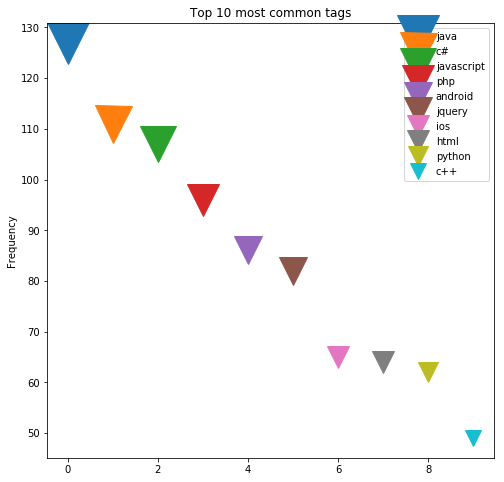

In [14]:
tags_tally = collections.Counter(tags_df['Tag'])

# x = tag name, y = tag frequency
x, y = zip(*tags_tally.most_common(10))

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

area = [i/3 for i in list(y)]   # 0 to 15 point radiuses
plt.figure(figsize=(8,8))
plt.ylabel("Frequency")
plt.title("Top 10 most common tags")
for i in range(len(y)):
        plt.plot(i,y[i], marker='v', linestyle='',ms=area[i],label=x[i])

plt.legend(numpoints=1)
plt.show()

**Distribution  - number of answers per question**

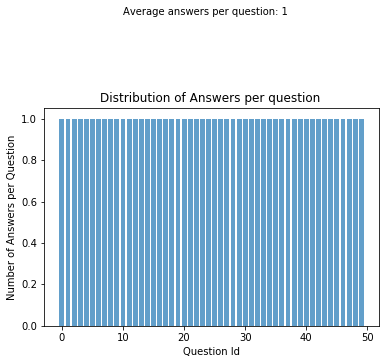

In [15]:
ans_per_question = collections.Counter(answers_df['ParentId'])
answerid,noAnswers= zip(*ans_per_question.most_common())

N=50
plt.bar(range(N), noAnswers[:N], align='center', alpha=0.7)
#plt.xticks(y_pos, objects)

plt.ylabel('Number of Answers per Question')
plt.xlabel('Question Id')
plt.title('Distribution of Answers per question ')
plt.text(10,1.5,"Average answers per question: "+str(math.floor((np.mean(noAnswers)))))

plt.show()